In [14]:
!pip install  mlflow pyngrok

In [15]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import mlflow
import mlflow.pytorch
from sklearn.metrics import classification_report
from pyngrok import ngrok
from getpass import getpass
import warnings

warnings.filterwarnings("ignore")
plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


## Dataset loader


In [16]:
data_dir = '../input/kermany2018/oct2017/OCT2017 '
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them

data_transforms = {
    TRAIN: transforms.Compose([

        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {  x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
    for x in [TRAIN, VAL, TEST]
}
print(image_datasets)

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

{'train': Dataset ImageFolder
    Number of datapoints: 83484
    Root location: ../input/kermany2018/oct2017/OCT2017 /train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           ), 'val': Dataset ImageFolder
    Number of datapoints: 32
    Root location: ../input/kermany2018/oct2017/OCT2017 /val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
           ), 'test': Dataset ImageFolder
    Number of datapoints: 968
    Root location: ../input/kermany2018/oct2017

In [17]:
print(image_datasets[TRAIN].classes)

['CNV', 'DME', 'DRUSEN', 'NORMAL']


torch.Size([3, 228, 1810])
(228, 1810, 3)


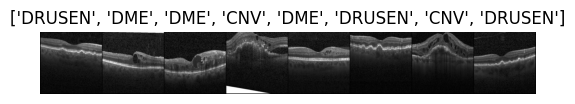

In [18]:
def imshow(inp, title=None):
    print(inp.size())

    print((inp.numpy().transpose((1, 2,0)).shape))
    inp = inp.numpy().transpose((1, 2,0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TEST]))
show_databatch(inputs, classes)

In [19]:

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=True,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    try:
        mlflow.log_figure(plt.gcf(), "confusion_matrix.png")
    except Exception as e:
        print(f"Could not log figure to MLflow: {e}")

    plt.show()

## Model creation

The [VGG-16](https://www.quora.com/What-is-the-VGG-neural-network) is able to classify 1000 different labels; we just need 4 instead. 
In order to do that we are going replace the last fully connected layer of the model with a new one with 4 output features instead of 1000. 

In PyTorch, we can access the VGG-16 classifier with `model.classifier`, which is an 6-layer array. We will replace the last entry.

We can also disable training for the convolutional layers setting `requre_grad = False`, as we will only train the fully connected classifier.

In [20]:
vgg16 = models.vgg16_bn(pretrained=True)

In [21]:
vgg16.classifier[6] = nn.Linear(4096, 4)

In [22]:

for name, param in vgg16.named_parameters():
    print(name, param.requires_grad)


features.0.weight True
features.0.bias True
features.1.weight True
features.1.bias True
features.3.weight True
features.3.bias True
features.4.weight True
features.4.bias True
features.7.weight True
features.7.bias True
features.8.weight True
features.8.bias True
features.10.weight True
features.10.bias True
features.11.weight True
features.11.bias True
features.14.weight True
features.14.bias True
features.15.weight True
features.15.bias True
features.17.weight True
features.17.bias True
features.18.weight True
features.18.bias True
features.20.weight True
features.20.bias True
features.21.weight True
features.21.bias True
features.24.weight True
features.24.bias True
features.25.weight True
features.25.bias True
features.27.weight True
features.27.bias True
features.28.weight True
features.28.bias True
features.30.weight True
features.30.bias True
features.31.weight True
features.31.bias True
features.34.weight True
features.34.bias True
features.35.weight True
features.35.bias True


## Let us now exclude some of features layers

In [23]:
for param in vgg16.features[:30].parameters():
    param.requires_grad = False

In [24]:
for name, param in vgg16.named_parameters():
    print(name, param.requires_grad)

features.0.weight False
features.0.bias False
features.1.weight False
features.1.bias False
features.3.weight False
features.3.bias False
features.4.weight False
features.4.bias False
features.7.weight False
features.7.bias False
features.8.weight False
features.8.bias False
features.10.weight False
features.10.bias False
features.11.weight False
features.11.bias False
features.14.weight False
features.14.bias False
features.15.weight False
features.15.bias False
features.17.weight False
features.17.bias False
features.18.weight False
features.18.bias False
features.20.weight False
features.20.bias False
features.21.weight False
features.21.bias False
features.24.weight False
features.24.bias False
features.25.weight False
features.25.bias False
features.27.weight False
features.27.bias False
features.28.weight False
features.28.bias False
features.30.weight True
features.30.bias True
features.31.weight True
features.31.bias True
features.34.weight True
features.34.bias True
features.3

In [27]:
def eval_model(vgg, LossFunction,plotConfutionMatrix=False):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    all_ground_truth_labels=[]
    all_predicted_labels=[]
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    with torch.no_grad():  # Disable gradient calculations
        for i, data in enumerate(dataloaders[TEST]):
                
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

            inputs, labels = data
            
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = LossFunction(outputs, labels)

            loss_test += loss.data.item()
            acc_test += torch.sum(preds == labels.data)



            all_ground_truth_labels.extend(labels.data)
            all_predicted_labels.extend(preds)
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()

        avg_loss = loss_test / dataset_sizes[TEST]
        avg_acc = acc_test / dataset_sizes[TEST]
        all_ground_truth_labels = torch.tensor(all_ground_truth_labels)
        all_predicted_labels = torch.tensor(all_predicted_labels)

        report=classification_report(all_ground_truth_labels, all_predicted_labels,output_dict=True)

        mlflow.log_metrics({
            'accuracy': report['accuracy'],
            'F1-score_class_CNV': report['0']['f1-score'],
            'F1-score_class_DME': report['1']['f1-score'],
            'F1-score_class_DRUSEN': report['2']['f1-score'],
            'F1-score_class_NORMAL': report['3']['f1-score'],
            'f1_score_macro': report['macro avg']['f1-score']
        })  
        cm= confusion_matrix(all_ground_truth_labels.cpu().numpy(),all_predicted_labels.cpu().numpy())  
        if(plotConfutionMatrix):
            plot_confusion_matrix(cm,['CNV', 'DME', 'DRUSEN', 'NORMAL'])


        elapsed_time = time.time() - since

        print()
        print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
        print("Avg loss (test): {:.4f}".format(avg_loss))
        print("Avg acc (test): {:.4f}".format(avg_acc))
        print('-' * 10)

In [28]:
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
LossFunction = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Training


In [29]:
get_ipython().system_raw("mlflow ui --port 5000 &")
mlflow.pytorch.autolog()
# IMP: please create a auth token from https://dashboard.ngrok.com/auth by creating an account. 
# the below auth ticket will not work for anyone re-running the notebook.
    
from pyngrok import ngrok
from getpass import getpass

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2n2IMplnGHRlYWqp8kc7Tqf4H3I_3QkfcpSxHbqmQPzMnKXg7"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

[2024-10-15 11:14:04 +0000] [180] [INFO] Starting gunicorn 23.0.0
[2024-10-15 11:14:04 +0000] [180] [INFO] Listening at: http://127.0.0.1:5000 (180)
[2024-10-15 11:14:04 +0000] [180] [INFO] Using worker: sync
[2024-10-15 11:14:04 +0000] [181] [INFO] Booting worker with pid: 181
[2024-10-15 11:14:04 +0000] [182] [INFO] Booting worker with pid: 182
[2024-10-15 11:14:04 +0000] [183] [INFO] Booting worker with pid: 183
[2024-10-15 11:14:04 +0000] [184] [INFO] Booting worker with pid: 184


MLflow Tracking UI: https://2f6a-35-233-196-241.ngrok-free.app                                      


In [30]:
def train_model(vgg, LossFunction, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg)

    best_acc = 0.0
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    learning_rates=[0.01,0.009]
    momentum_values=[0.8,0.9]
    val_batches = len(dataloaders[VAL])
    model_number=0
    
    for lr in learning_rates:
        for momentum in momentum_values:
            model_number+=1
            optimizer_ft = optim.SGD(vgg16.parameters(), lr=lr, momentum=momentum)
            print("___________________________________________________")            
            print(f"Model_{model_number}")            
            print(f"For hyperparameters:LR:{lr},Momentum:{momentum}")


            with mlflow.start_run(run_name=f"Model_{model_number}",nested=True):  

                model = copy.deepcopy(vgg)

                for epoch in range(num_epochs):
                    print("Epoch {}/{}".format(epoch, num_epochs))
                    print('-' * 10)

                    loss_train = 0
                    loss_val = 0
                    acc_train = 0
                    acc_val = 0

                    model.train(True)

                    for i, data in enumerate(dataloaders[TRAIN]):
                        if i % 50 == 0:
                            print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)

                    
                        if i >= train_batches / 2:
                            break

                        inputs, labels = data

                        if use_gpu:
                            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                        else:
                            inputs, labels = Variable(inputs), Variable(labels)

                        optimizer.zero_grad()

                        outputs = model(inputs)

                        _, preds = torch.max(outputs.data, 1)

                        loss = LossFunction(outputs, labels)

                        loss.backward()
                        optimizer.step()

                        loss_train += loss.data.item()
                        acc_train += torch.sum(preds == labels.data)

                        del inputs, labels, outputs, preds
                        torch.cuda.empty_cache()



                    avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
                    avg_acc = acc_train * 2/ dataset_sizes[TRAIN]

                    with torch.no_grad():  # Disable gradient calculations

                        for i, data in enumerate(dataloaders[VAL]):
                            
                            print("\rValidation batch {}/{}".format(i, val_batches),  flush=True)

                            inputs, labels = data

                            if use_gpu:
                                inputs, labels = inputs.cuda(), labels.cuda()


                            optimizer.zero_grad()

                            outputs = model(inputs)

                            _, preds = torch.max(outputs.data, 1)
                            loss = LossFunction(outputs, labels)

                            loss_val += loss.data.item()
                            acc_val += torch.sum(preds == labels.data)


                    avg_loss_val = loss_val / dataset_sizes[VAL]
                    avg_acc_val = acc_val / dataset_sizes[VAL]

                    print("Epoch {} result: ".format(epoch))
                    print("Avg loss (train): {:.3f}".format(avg_loss))
                    print("Avg acc (train): {:.3f}".format(avg_acc))
                    print("Avg loss (val): {:.3f}".format(avg_loss_val))
                    print("Avg acc (val): {:.3f}".format(avg_acc_val))
                    print('-' * 10)

                    if avg_acc_val > best_acc:
                        best_acc = avg_acc_val
                        best_model_wts = copy.deepcopy(model.state_dict())
                eval_model(model, LossFunction)                
                mlflow.log_params({'LR':lr,
                                  'Momentum':momentum})



                elapsed_time = time.time() - since

            print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [ ]:
mlflow.set_experiment("Retinal OCT Pytoch classification")
mlflow.set_tracking_uri("http://localhost:5000")

vgg16 = train_model(vgg16, LossFunction, optimizer_ft, exp_lr_scheduler, num_epochs=3)
torch.save(vgg16.state_dict(), 'VGG16_v2-OCT_Retina_half_dataset.pt')

2024/10/15 11:18:20 INFO mlflow.tracking.fluent: Experiment with name 'Retinal OCT Pytoch classification' does not exist. Creating a new experiment.


___________________________________________________
Model_1
For hyperparameters:LR:0.01,Momentum:0.8
Epoch 0/3
----------
Validation batch 0/45218.0
Validation batch 1/4
Validation batch 2/4
Validation batch 3/4
Epoch 0 result: 
Avg loss (train): 0.174
Avg acc (train): 0.268
Avg loss (val): 0.167
Avg acc (val): 0.375
----------
Epoch 1/3
----------
Validation batch 0/45218.0
Validation batch 1/4
Validation batch 2/4
Validation batch 3/4
Epoch 1 result: 
Avg loss (train): 0.175
Avg acc (train): 0.269
Avg loss (val): 0.174
Avg acc (val): 0.344
----------
Epoch 2/3
----------
Training batch 1000/5218.0

In [ ]:
eval_model(vgg16, LossFunction,plotConfutionMatrix=True)